## INITIALIZATION

In [1]:
%matplotlib notebook
import numpy as np
import time
import tables as tb
import matplotlib.pyplot as plt

from tjmonopix.tjmonopix import TJMonoPix
from tjmonopix.online_monitor import noise_monitor, plots
from tjmonopix.analysis import analysis_functions

import tjmonopix.scans.injection_scan

chip = TJMonoPix(conf="../tjmonopix/tjmonopix_mio3.yaml", no_power_reset=False)
chip.init(fl="EN_HV")

chip['data_rx'].CONF_START_FREEZE = 64 #default 3
chip['data_rx'].CONF_STOP_FREEZE = 100 #default 40
chip['data_rx'].CONF_START_READ = 66 #default 6
chip['data_rx'].CONF_STOP_READ = 68 #default 7
chip['data_rx'].CONF_STOP = 105 #default 45


2022-02-10 10:12:29,928 [INFO ] (MainThread) GPAC: power reset
2022-02-10 10:12:31,684 [INFO ] (MainThread) Found adapter card: General Purpose Analog Card (GPAC) with ID 3
2022-02-10 10:12:31,924 [INFO ] (MainThread) Found board 0 running firmware version 0.0
2022-02-10 10:12:32,164 [INFO ] (MainThread) ibias = 45
2022-02-10 10:12:32,184 [INFO ] (MainThread) ibias = 503.125 nA
2022-02-10 10:12:32,773 [INFO ] (MainThread) {'VPC [V]': 1.2998506463536463, 'VDDA_DAC [mA]': 2.502471747485684, 'VDDP [V]': 1.8059798142570278, 'VDDP OC': False, 'VDDA [mA]': 50.151368865825674, 'VDDD [V]': 1.8015140363636364, 'VDDA_DAC OC': False, 'VDDD [mA]': 2.820288999038665e-08, 'VPCSWSF [V]': 0.5006537, 'VDDP [mA]': 128.39714805315754, 'BiasSF [V]': 1.0602797331139773, 'VDDD OC': False, 'VPC [mA]': -0.46899792860743095, 'VPCSWSF [mA]': -0.019509674604491503, 'VDDA [V]': 1.8058565495495498, 'VDDA OC': False, 'VDDA_DAC [V]': 1.8045472377622378, 'BiasSF [mA]': 0.10059447096451782}


## POWER STATUS

In [2]:
#chip['BiasSF'].set_current(100, unit='uA') # SET THE SOURCE FOLLOWER READOUT CURRENT
chip.get_power_status()

{'BiasSF [V]': 1.0612799558568045,
 'BiasSF [mA]': 0.10109892318840588,
 'VDDA OC': False,
 'VDDA [V]': 1.8058565495495498,
 'VDDA [mA]': 50.151368865825674,
 'VDDA_DAC OC': False,
 'VDDA_DAC [V]': 1.8035484515484517,
 'VDDA_DAC [mA]': 2.502471747485684,
 'VDDD OC': False,
 'VDDD [V]': 1.8015140363636364,
 'VDDD [mA]': 2.820288999038665e-08,
 'VDDP OC': False,
 'VDDP [V]': 1.8049802771084336,
 'VDDP [mA]': 128.39714805315754,
 'VPC [V]': 1.2998506463536463,
 'VPC [mA]': -0.19249914667417387,
 'VPCSWSF [V]': 0.5001542395802099,
 'VPCSWSF [mA]': -0.15857868007065865}

In [ ]:
"""
# SELECT WHICH DOUBLE COLUMNS (PIXEL "FLAVOURS") TO ENABLE
chip['CONF_SR']['EN_PMOS_NOSF'].setall(False)
chip['CONF_SR']['EN_PMOS'].setall(False)
chip['CONF_SR']['EN_COMP'].setall(False)
chip['CONF_SR']['EN_HV'].setall(True)
chip['CONF_SR']['EN_OUT'].setall(False) #ENABLES OR DISABLES THE NORMAL OUTPUT PADS, ACTIVE LOW
chip['CONF_SR']['nEN_OUT'].setall(True) #ENABLES OR DISABLES THE COMPLEMENTARY OUTPUT PADS, ACTIVE LOW
chip['CONF_SR']['EN_HITOR_OUT'].setall(True) #ENABLES OR DISABLES THE NORMAL HITOR PADS, HITOR0-3 =  1-4 flavor, ACTIVE LOW
chip['CONF_SR']['nEN_HITOR_OUT'].setall(True) #ENABLES OR DISABLES THE COMPLEMENTARY HITOR PADS, ACTIVE LOW
chip.write_conf()

# SELECT WHICH PHYSICAL COLUMS TO INJECT
# INJ_IN_MON_L AND INJ_IN_MON_L SELECT THE LEFT AND RIGHT SPECIAL ANALOG MONITORING PIXELS
chip['CONF_SR']['COL_PULSE_SEL'].setall(False)

chip['CONF_SR']['INJ_IN_MON_L'] = 1 # ENABLE INJECTION FOR THE ANALOG MONITORING PIXELS LEFT SIDE
chip['CONF_SR']['INJ_IN_MON_R'] = 1 # ENABLE INJECTION FOR THE ANALOG MONITORING PIXELS RIGHT SIDE

# SELECT WHICH PHYSICAL ROWS TO INJECT
# THE SPEXIAL PIXELS OUTA_MON3 to OUTA_MON0 CORRESPONT TO ROWS 223 to 220 FOR INJECTION
chip['CONF_SR']['INJ_ROW'].setall(False)
chip['CONF_SR']['INJ_ROW'][223:220] = True # FOR THE ANALOG MONITORING TOP PIXEL

# SELECT PHYSICAL COLUMNS AND ROWS FOR INJECTION WITH FUNCTION
#chip.enable_injection(3,18,99)
chip.write_conf()


# SELECT PHYSICAL COLUMN(S) FOR HITOR OUTPUT
# nMASKH (SO SETTING MASKH TO FALSE) ENABLES HITOR FOR THE SPECIFIC ROW
chip['CONF_SR']['DIG_MON_SEL'].setall(False)
#chip.enable_column_hitor(1,18)

chip.write_conf()
"""

## ANALOG FRONT END CONFIGURATION

In [3]:
vl_dac = 40
vh_dac = 80
vreset_dac = 35
icasn_dac = 0  # This sets the baseline voltage of the discriminator input
ireset_dac = 2
ithr_dac = 5  # Also this sets the baseline voltage of the discriminator input
idb_dac = 50  # This sets the threshold of the discriminator. It is changed later.
ibias_dac = 100

## SET THE INJECTION PULSE AMPLITUDE
## 128-bit DAC (7-bit binary equivalent)
## SET THE VOLTAGES IN ONE HOT ENCODING, ONLY ONE BIT ACTIVE AT A TIME.
## V = (127/1.8)*#BIT
# The default values are VL=44, VH=79, VH-VL=35
# VDAC LSB=14.17mV, Cinj=230aF, 1.43e-/mV, ~710e-  
CAPCAL=20.3439450687
vl = chip.set_vl_dacunits(vl_dac,1)
vh = chip.set_vh_dacunits(vh_dac,1)

chip.write_conf()

# SET VRESET_P, THIS IS THE BASELINE OF THE FRONT END INPUT, ONE HOT ENCODING
vreset = chip.set_vreset_dacunits(vreset_dac, 1) #1V

## 128-bit DAC (7-bit binary equivalent)
## SET THE CURRENTS USING THERMOMETER ENCODING, I = #BITS_ACTIVE*140nA*SCALING, SCALING IS DIFFERENT FOR EACH CURRENT
## SCALING: IBIAS=10, IDB=16, ITHR=0.125, ICASN=4, IRESET=0.03125
## ACTIVE BITS SHOULD BE SET STARTING FROM THE MIDDLE e.g. for 15 active bits, (128-15)/2=56,5 so 56zeros,15ones,57zeros
## Thus, Ix[71:57] = True

# SET ICASN, THIS CURRENT CONTROLS THE OUTPUT BASELINE, BE CAREFUL NOT TO SET IT TO HIGH
# ALWAYS MONITOR THE POWER AFTER SETTING ICASN. IF VDDD IS SEVERAL mA, REDUCE IT UNTIL IT RETURNS TO 0
# ICASN MAINLY CONTROLS THE THRESHOLD
icasn = chip.set_icasn_dacunits(icasn_dac,1) #4.375nA # approx 1.084V at -3V backbias, 600mV at 0V backbias

# SET IRESET, THIS CURRENT CONTROLS THE RESET RATE OF THE FRONT END INPUT (ALSO THE THRESHOLD)
ireset = chip.set_ireset_dacunits(ireset_dac,1,1) #270pA, HIGH LEAKAGE MODE, NORMAL SCALING, 0 = LOW LEAKAGE MODE, SCALING*0.01

# SET ITHR, THIS CURRENT CONTROLS THE RESET RATE OF THE OUTPUT (AND THE THRESHOLD)
ithr = chip.set_ithr_dacunits(ithr_dac,1) #680pA ## default=5

# SET ITHR, THIS CURRENT CONTROLS THE BIASING OF THE DISCRIMINATOR (AND THE THRESHOLD)
idb = chip.set_idb_dacunits(idb_dac,1) #500nA  

# SET IBIAS, THIS CURRENT IS THE DC CURRENT OF THE MAIN BRANCH OF THE FRONT END THAT PROVIDES AMPLIFICATION
# IT CONTROLS MAINLY THE RISE TIME
ibias = chip.set_ibias_dacunits(ibias_dac,1) #500nA default=50

############ ENABLE THE DAC CURRENT MONITORING ###########
# chip['CONF_SR']['SWCNTL_DACMONI'] = 0

########## SET THE BIAS CURRENTS OF THE TWO STAGE SOURCE FOLLOWER THAT BUFFERS THE ANALOG MONITORING VOLTAGES #########
# CONTROLS THE RESPONSE TIME AND THE LEVEL SHIFT OF THE BUFFER
# chip['CONF_SR']['SET_IBUFN_L'] = 0b1001
# chip['CONF_SR']['SET_IBUFP_L'] = 0b0101

chip.write_conf()


setted_param_dac = np.array([vl_dac, vh_dac, vreset_dac, icasn_dac, ireset_dac, ithr_dac, idb_dac, ibias_dac])
setted_param = np.array([vl, vh, vreset, icasn, ireset, ithr, idb, ibias])

2022-02-10 10:12:40,621 [INFO ] (MainThread) vl = 0.951929133858V
2022-02-10 10:12:40,638 [INFO ] (MainThread) vh = 1.51885826772V
2022-02-10 10:12:40,653 [INFO ] (MainThread) vreset = 1.05106299213V
2022-02-10 10:12:40,668 [INFO ] (MainThread) icasn = 0
2022-02-10 10:12:40,684 [INFO ] (MainThread) icasn = 4.375 nA
2022-02-10 10:12:40,700 [INFO ] (MainThread) ireset = 2 high leakage mode
2022-02-10 10:12:40,736 [INFO ] (MainThread) ireset = 0.1025390625nA, high leakage mode
2022-02-10 10:12:40,753 [INFO ] (MainThread) ithr = 5
2022-02-10 10:12:40,769 [INFO ] (MainThread) ithr = 0.8203125 nA
2022-02-10 10:12:40,785 [INFO ] (MainThread) idb = 50
2022-02-10 10:12:40,801 [INFO ] (MainThread) idb = 892.5 nA
2022-02-10 10:12:40,816 [INFO ] (MainThread) ibias = 100
2022-02-10 10:12:40,836 [INFO ] (MainThread) ibias = 1104.6875 nA


## ENABLE MASK AND GET OCCUPANCY

In [4]:
th = 2
step = 50
dt = 0.2

noisy_pixels, n_disabled_pixels, mask = chip.auto_mask(th=th, step=step, dt=dt)
print("========= Getting residual occupancy =============")
pix_tmp, cnt = chip.get_occupancy(dt);

Enable MASKH 50
Got 54872 hits, total noisy pixels: 37
Enable MASKH 100
Got 117409 hits, total noisy pixels: 100
Enable MASKH 150
Got 26888 hits, total noisy pixels: 149
Enable MASKH 200
Got 165467 hits, total noisy pixels: 223
Enable MASKH 223
Got 43557 hits, total noisy pixels: 244
Enable MASKV 50
Got 56 hits, total noisy pixels: 247
Enable MASKV 100
Got 59 hits, total noisy pixels: 249
Enable MASKV 111
Got 62 hits, total noisy pixels: 253
Enable MASKD 50
Got 74 hits, total noisy pixels: 254
Enable MASKD 100
Got 24 hits, total noisy pixels: 256
Enable MASKD 150
Got 15 hits, total noisy pixels: 258
Enable MASKD 200
Got 34 hits, total noisy pixels: 261
Enable MASKD 250
Got 13 hits, total noisy pixels: 265
Enable MASKD 300
Got 60 hits, total noisy pixels: 267
Enable MASKD 350
Got 33 hits, total noisy pixels: 269
Enable MASKD 400
Got 59 hits, total noisy pixels: 269
Enable MASKD 447
Got 83 hits, total noisy pixels: 271
Checking again after masking
Got 48 hits, total noisy pixels: 271
Noi

# Configure injection and Select 1pixel 

2022-02-10 10:12:55,036 [INFO ] (MainThread) idb = 50
2022-02-10 10:12:55,052 [INFO ] (MainThread) idb = 892.5 nA
2022-02-10 10:12:55,068 [INFO ] (MainThread) vh = 1.80232283465V


('pixel (col and row) injected', 66, 10)
Got 154 hits in 0.2 s


<IPython.core.display.Javascript object>


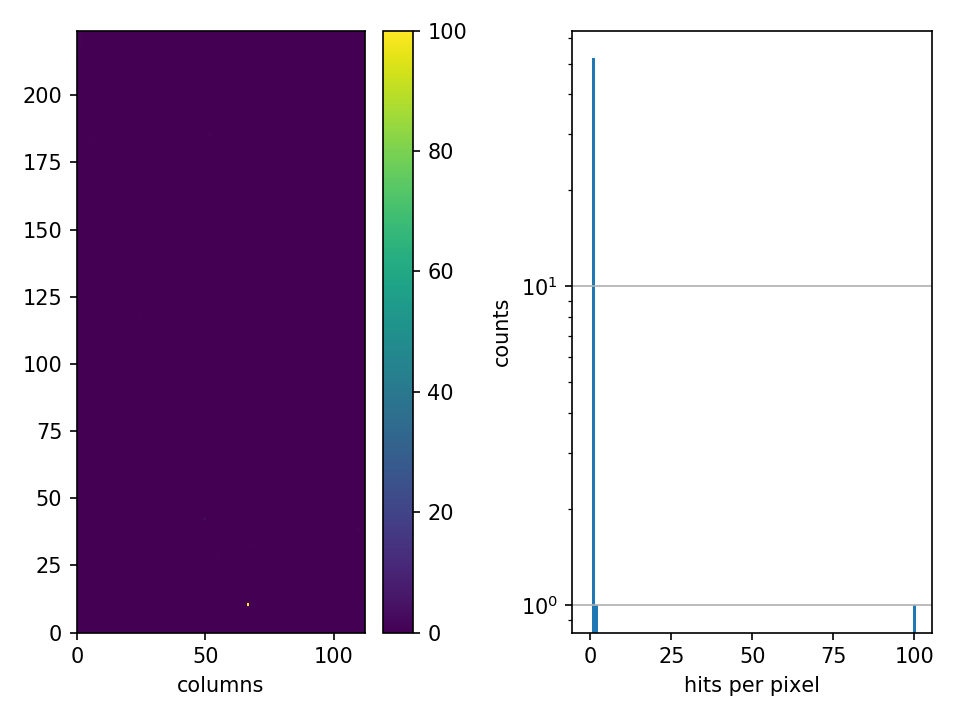

2022-02-10 10:12:57,651 [WARNI] (MainThread) Deprecated: Use get_FIFO_SIZE()


fifo size 1272
0 (66, 10) 100
1 (49, 42) 1
2 (36, 166) 1
3 (8, 178) 1
4 (6, 182) 1
5 (2, 72) 1
6 (1, 205) 1


In [5]:
import tjmonopix.scans.injection_scan
reload(tjmonopix.scans.injection_scan)

delay = 800 #in clock units (640 MHz)
width = 250
repeat = 100 #number of pulse injected
chip['inj'].set_delay(delay)
chip['inj'].set_width(width)
chip['inj'].set_repeat(repeat)
chip['inj'].set_phase(0)
chip['inj'].set_en(0)

idb = chip.set_idb_dacunits(50,1) #### threshold; SOPRA LA METTE CON 50 DAC
vh = chip.set_vh_dacunits(100,1) #### injection; SOPRA LA METTE CON 80 DAC
chip.write_conf()

col_to_inject = 66
row_to_inject = 10
chip.select_injection(col_to_inject, row_to_inject)

_, pixels, hits_per_pixel = plots.tj_plot(chip, wait_inj=True)
chip['data_rx'].set_en(False)

chip.set_monoread()
for _ in range(5):
    chip['fifo'].reset()
    time.sleep(0.002)
chip["inj"].start()
while not chip['inj'].is_ready:
    time.sleep(0.001)
time.sleep(0.2)

print "fifo size", chip['fifo'].get_fifo_size()
ix = chip.interpret_data(chip['fifo'].get_data())
uni, cnt = np.unique(ix[["col","row"]], return_counts = True)
arg = np.argsort(cnt)
for a_i, a in enumerate(arg[::-1]):
    print a_i, uni[a], cnt[a]
    

## run parameter space scan using injection_scan

In [10]:
delay = 800 #in clock units (640 MHz)
width = 250
repeat = 100 #number of pulse injected
chip['inj'].set_delay(delay)
chip['inj'].set_width(width)
chip['inj'].set_repeat(repeat)
chip['inj'].set_phase(0)
chip['inj'].set_en(0)

idb = chip.set_idb_dacunits(20,1) 
vh = chip.set_vh_dacunits(80,1) # The functions below change vl w.r.t. vh
chip.write_conf()

scans = tjmonopix.scans.injection_scan.InjectionScan(dut=chip)

collist = list(range(80, 85))
rowlist = list(range(224))
injlist = np.arange(50, 0, -1)
thlist = list(range(20, 30))

output_filename = scans.start(
    collist = collist, rowlist = rowlist,
    injlist = injlist, thlist = thlist, phaselist = None,
    with_mon = False, n_mask_col = 5, debug = 4)

scans.analyze(output_filename)

2022-02-10 10:56:08,867 [INFO ] (MainThread) idb = 20
2022-02-10 10:56:08,881 [INFO ] (MainThread) idb = 367.5 nA
2022-02-10 10:56:08,898 [INFO ] (MainThread) vh = 1.51885826772V
2022-02-10 10:56:08,914 [INFO ] (MainThread) Initializing InjectionScan
2022-02-10 10:56:09,499 [INFO ] (MainThread) Power status: {'VPC [V]': 1.2998506463536463, 'VDDA_DAC [mA]': 2.502471747485684, 'VDDP [V]': 1.8049802771084336, 'VDDP OC': False, 'VDDA [mA]': 78.01324044508196, 'VDDD [V]': 1.8015140363636364, 'VDDA_DAC OC': False, 'VDDD [mA]': 2.820288999038665e-08, 'VPCSWSF [V]': 0.5001542395802099, 'VDDP [mA]': 129.40418450829804, 'BiasSF [V]': 1.062780289971045, 'VDDD OC': False, 'VPC [mA]': -0.006499966060843606, 'VPCSWSF [mA]': 0.20960401065991338, 'VDDA [V]': 1.8038584294294295, 'VDDA OC': False, 'VDDA_DAC [V]': 1.8045472377622378, 'BiasSF [mA]': 0.10059447096451782}
2022-02-10 10:56:09,585 [INFO ] (MainThread) Temperature (C): 29.159613
2022-02-10 10:56:09,650 [INFO ] (MainThread) Temperature (C): 29.

sleeping


2022-02-10 10:56:24,759 [INFO ] (MainThread) Set timestamp: src=inj
2022-02-10 10:56:25,434 [INFO ] (MainThread) Starting FIFO readout


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)

('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)

('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)
('row', 3)

('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)
('row', 4)

('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)
('row', 6)

('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)
('row', 7)

('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)
('row', 9)

('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('row', 10)
('ro

('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 11)
('row', 12)
('row', 12)
('row', 12)
('row', 12)
('row', 12)
('row', 12)
('row', 12)
('row', 12)
('row', 12)
('row', 12)
('row', 12)
('row', 12)
('row', 12)
('ro

('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('row', 13)
('ro

('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('row', 14)
('ro

('row', 15)
('row', 15)
('row', 15)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('row', 16)
('ro

('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('row', 17)
('ro

('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('ro

('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('ro

('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('row', 21)
('ro

('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 22)
('row', 23)
('row', 23)
('row', 23)
('row', 23)
('row', 23)
('row', 23)
('row', 23)
('row', 23)
('row', 23)
('row', 23)
('row', 23)
('row', 23)
('row', 23)
('row', 23)
('row', 23)
('row', 23)
('row', 23)
('row', 23)
('row', 23)
('ro

('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('row', 24)
('ro

('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('row', 25)
('ro

('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('row', 27)
('ro

('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('row', 28)
('ro

('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('row', 29)
('ro

('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('row', 31)
('ro

('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('row', 32)
('ro

('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 33)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('row', 34)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('ro

('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('ro

('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('row', 38)
('ro

('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('row', 39)
('ro

('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('row', 40)
('ro

('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('row', 42)
('ro

('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('row', 43)
('ro

('row', 44)
('row', 44)
('row', 44)
('row', 44)
('row', 44)
('row', 44)
('row', 44)
('row', 44)
('row', 44)
('row', 44)
('row', 44)
('row', 44)
('row', 44)
('row', 44)
('row', 44)
('row', 44)
('row', 44)
('row', 44)
('row', 44)
('row', 44)
('row', 44)
('row', 44)
('row', 44)
('row', 44)
('row', 44)
('row', 44)
('row', 44)
('row', 44)
('row', 44)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('row', 45)
('ro

('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('row', 46)
('ro

('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('row', 47)
('ro

('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('row', 49)
('ro

('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('row', 50)
('ro

('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('row', 51)
('ro

('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('ro

('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 55)
('row', 55)
('row', 55)
('row', 55)
('row', 55)
('row', 55)
('row', 55)
('row', 55)
('row', 55)
('row', 55)
('row', 55)
('row', 55)
('row', 55)
('row', 55)
('row', 55)
('row', 55)
('row', 55)
('row', 55)
('row', 55)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('row', 56)
('ro

('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('row', 57)
('ro

('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('row', 58)
('ro

('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('row', 60)
('ro

('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('row', 61)
('ro

('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 62)
('row', 63)
('row', 63)
('row', 63)
('row', 63)
('row', 63)
('row', 63)
('row', 63)
('row', 63)
('row', 63)
('row', 63)
('row', 63)
('row', 63)
('row', 63)
('ro

('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('row', 64)
('ro

('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('row', 65)
('ro

('row', 66)
('row', 66)
('row', 66)
('row', 66)
('row', 66)
('row', 66)
('row', 66)
('row', 66)
('row', 66)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('row', 67)
('ro

('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('row', 68)
('ro

('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('ro

('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('ro

('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('ro

('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 73)
('row', 74)
('row', 74)
('row', 74)
('row', 74)
('row', 74)
('row', 74)
('row', 74)
('row', 74)
('row', 74)
('row', 74)
('row', 74)
('row', 74)
('row', 74)
('row', 74)
('row', 74)
('ro

('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('row', 75)
('ro

('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('row', 76)
('ro

('row', 77)
('row', 77)
('row', 77)
('row', 77)
('row', 77)
('row', 77)
('row', 77)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('row', 78)
('ro

('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('row', 79)
('ro

('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('row', 80)
('ro

('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('row', 82)
('ro

('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('row', 83)
('ro

('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 84)
('row', 85)
('row', 85)
('row', 85)
('row', 85)
('row', 85)
('row', 85)
('row', 85)
('row', 85)
('row', 85)
('row', 85)
('row', 85)
('ro

('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('ro

('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('ro

('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('ro

('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('row', 90)
('ro

('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('row', 91)
('ro

('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('row', 93)
('ro

('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('row', 94)
('ro

('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 95)
('row', 96)
('row', 96)
('row', 96)
('row', 96)
('row', 96)
('row', 96)
('row', 96)
('row', 96)
('row', 96)
('row', 96)
('ro

('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('row', 97)
('ro

('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('row', 98)
('ro

('row', 99)
('row', 99)
('row', 99)
('row', 99)
('row', 99)
('row', 99)
('row', 99)
('row', 99)
('row', 99)
('row', 99)
('row', 99)
('row', 99)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100)
('row', 100

('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)
('row', 101)

('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)
('row', 102)

('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)

('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)

('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)

('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)
('row', 107)

('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 108)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)
('row', 109)

('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)
('row', 110)

('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)
('row', 111)

('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)
('row', 112)

('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)
('row', 114)

('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)
('row', 115)

('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)
('row', 116)

('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 117)
('row', 118)
('row', 118)
('row', 118)
('row', 118)
('row', 118)
('row', 118)

('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)

('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)

('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)

('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)
('row', 123)

('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)
('row', 124)

('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)
('row', 125)

('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)
('row', 126)

('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)
('row', 128)

('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)
('row', 129)

('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)
('row', 130)

('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 131)
('row', 132)
('row', 132)
('row', 132)
('row', 132)
('row', 132)
('row', 132)

('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)
('row', 133)

('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)
('row', 134)

('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)

('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)

('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)
('row', 138)

('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)
('row', 139)

('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)
('row', 140)

('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)
('row', 142)

('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)
('row', 143)

('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)
('row', 144)

('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 145)
('row', 146)
('row', 146)
('row', 146)
('row', 146)
('row', 146)
('row', 146)
('row', 146)
('row', 146)
('row', 146)
('row', 146)
('row', 146)
('row', 146)
('row', 146)
('row', 146)
('row', 146)
('row', 146)
('row', 146)
('row', 146)
('row', 146)
('row', 146)
('row', 146)
('row', 146)
('row', 146)
('row', 146)
('row', 146)
('row', 146)

('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)
('row', 147)

('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)
('row', 148)

('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)
('row', 149)

('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)

('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)

('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)

('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)
('row', 154)

('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)
('row', 156)

('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)
('row', 157)

('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)
('row', 158)

('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 159)
('row', 160)
('row', 160)
('row', 160)
('row', 160)
('row', 160)
('row', 160)
('row', 160)
('row', 160)
('row', 160)
('row', 160)
('row', 160)
('row', 160)
('row', 160)
('row', 160)
('row', 160)
('row', 160)
('row', 160)
('row', 160)
('row', 160)
('row', 160)
('row', 160)

('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)
('row', 161)

('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)
('row', 162)

('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)
('row', 163)

('row', 164)
('row', 164)
('row', 164)
('row', 164)
('row', 164)
('row', 164)
('row', 164)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)
('row', 165)

('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)

('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)

('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)

('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)
('row', 170)

('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)
('row', 171)

('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)
('row', 172)

('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 173)
('row', 174)
('row', 174)
('row', 174)
('row', 174)
('row', 174)
('row', 174)
('row', 174)
('row', 174)
('row', 174)
('row', 174)
('row', 174)
('row', 174)
('row', 174)
('row', 174)
('row', 174)
('row', 174)
('row', 174)
('row', 174)
('row', 174)
('row', 174)
('row', 174)
('row', 174)
('row', 174)
('row', 174)

('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)
('row', 175)

('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)
('row', 176)

('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)
('row', 177)

('row', 178)
('row', 178)
('row', 178)
('row', 178)
('row', 178)
('row', 178)
('row', 178)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)
('row', 179)

('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)
('row', 180)

('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)
('row', 181)

('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)

('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)

('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)

('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)
('row', 186)

('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 187)
('row', 188)
('row', 188)
('row', 188)
('row', 188)
('row', 188)
('row', 188)
('row', 188)
('row', 188)
('row', 188)
('row', 188)

('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)
('row', 189)

('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)
('row', 190)

('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)
('row', 191)

('row', 192)
('row', 192)
('row', 192)
('row', 192)
('row', 192)
('row', 192)
('row', 192)
('row', 192)
('row', 192)
('row', 192)
('row', 192)
('row', 192)
('row', 192)
('row', 192)
('row', 192)
('row', 192)
('row', 192)
('row', 192)
('row', 192)
('row', 192)
('row', 192)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)
('row', 193)

('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)
('row', 194)

('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)
('row', 195)

('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)
('row', 196)

('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)

('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)

('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)

('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 202)
('row', 202)
('row', 202)

('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)
('row', 203)

('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)
('row', 204)

('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)
('row', 205)

('row', 206)
('row', 206)
('row', 206)
('row', 206)
('row', 206)
('row', 206)
('row', 206)
('row', 206)
('row', 206)
('row', 206)
('row', 206)
('row', 206)
('row', 206)
('row', 206)
('row', 206)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)
('row', 207)

('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)
('row', 208)

('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)
('row', 209)

('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)
('row', 210)

('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)
('row', 212)

('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)
('row', 213)

('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)

('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)

('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)

('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)
('row', 218)

('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)
('row', 219)

('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 220)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)
('row', 221)

('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)
('row', 222)

('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)

2022-02-10 11:27:20,114 [INFO ] (MainThread) scan_param_id=0 dat=141922716: cols=[80 81 82 83 84]


('row', 223)


2022-02-10 11:27:20,645 [INFO ] (MainThread) Stopped FIFO readout
2022-02-10 11:27:20,664 [INFO ] (MainThread) g=None, dat=0
2022-02-10 11:27:20,680 [INFO ] (MainThread) Recived words: 141922716
2022-02-10 11:27:20,698 [INFO ] (MainThread) Data queue size: 0
2022-02-10 11:27:20,716 [INFO ] (MainThread) SRAM FIFO size: 0
2022-02-10 11:27:20,730 [INFO ] (MainThread) Channel:                     TDC | DATA_RX | TLU | TIMESTAMP
2022-02-10 11:27:20,746 [INFO ] (MainThread) Discard counter:             None |       0 |   0 |         0
2022-02-10 11:27:21,331 [INFO ] (MainThread) Power status: {'VPC [V]': 1.2998506463536463, 'VDDA_DAC [mA]': 2.502471747485684, 'VDDP [V]': 1.8049802771084336, 'VDDP OC': False, 'VDDA [mA]': 78.01324044508196, 'VDDD [V]': 1.8015140363636364, 'VDDA_DAC OC': False, 'VDDD [mA]': 2.820288999038665e-08, 'VPCSWSF [V]': 0.5001542395802099, 'VDDP [mA]': 128.9006662807278, 'BiasSF [V]': 1.0632804013424586, 'VDDD OC': False, 'VPC [mA]': 0.1354994083858924, 'VPCSWSF [mA]':

0 99999999 70.461% 1.273s 33333333hits 0errs
100000000 41922715 100.000% 5.815s 13974239hits 0errs


KeyboardInterrupt: 